# Оценка результатов A/B-теста

**Описание проекта:**  
Проведен A/B тест для исследования изменений после внедрения улучшенной рекомендательной системы.  
Нужно оценить корректность проведения теста и его результаты.

**Цель исследования:**  

- проверить данные на соответствие техническому заданию, оценить корректность проведения теста;  
- проанализировать результаты теста.  

**Ход исследования**  
1. Обзор и предобработка данных  
   - поиск пропусков, обработка дат и строк, исследование уникальных значений в исходных датасетах  
   - объединение данных, обработка пропусков в новом датасете  
   
   
2. Оценка корректности проведения A/B теста  
   2.1 Соответствие данных техническому заданию  
   2.2 Совпадение теста по времени с маркетинговыми и другими активностями  
   2.3 Аудитория теста    
       2.3.1 Проверка пересечений с конкурирующим тестом  
       2.3.2 Проверка пользователей, участвующих в 2 группах теста одновременно  
       2.3.3 Горизонт анализа данных    
       2.3.4 Равномерность распределения клиентов по группам теста  
     
   2.4 Вывод по корректности проведения теста  
 
      
3. Исследовательский анализ данных  
   3.1 Одинаково ли число событий на пользователя в выборках  
   3.2 Распределение числа событий на день в выборках  
   3.3 Изменение конверсии на разных этапах воронки в выборках  
   3.4 Особенности данных, которые нужно учесть, прежде чем приступать к A/B-тестированию  
   
   
4. Оценка результатов A/B тестирования  
   4.1  Анализ результатов теста  
   4.2 Проверка статистической разницы долей z-критерием  
   
   
5. Общий вывод

**Техническое задание**  
**Назначение теста:**  тестирование изменений после внедрения улучшенной рекомендательной системы.  

**1.** Название теста: recommender_system_test  
**2.** Группы: А (контрольная), B (новая платёжная воронка)  

**3.** Дата запуска: 07-12-2020  
**4.** Дата остановки: 01-04-2021  
**5.** Дата остановки набора новых пользователей: 21-12-2020  
 
**6.** Аудитория теста - 15% новых пользователей из EU:  Доля новых клиентов из региона EU, принявших участие в тесте,  
от всех новых клиентов из EU, с датой регстрации по 21-12-2020 включительно.  

**7.** Ожидаемое количество участников теста: 6000  

**Ожидаемый эффект от улучшенной рекомендательной системы:**  
за 14 дней с момента регистрации пользователей каждая метрика улучшится не менее, чем на 10%:  

    конверсии в просмотр карточек товаров — событие product_page
    просмотры корзины — событие product_cart
    покупки — событие purchase.

**Описание данных**  
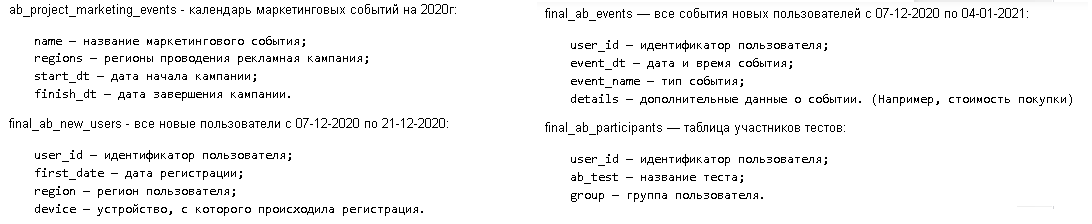

## Обзор и предобработка данных

In [1]:
#иимпорт библиотек
import pandas               as pd
from datetime import datetime, timedelta

import math                 as mth
import numpy                as np
import scipy.stats          as st
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot    as plt
import seaborn              as sns

import plotly.io            as pio
import plotly.express       as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from io import BytesIO
import requests

In [2]:
#отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [3]:
#опция показа таблиц - снятие ограничения на ширину столбцов
pd.set_option('display.max_colwidth', None)

In [4]:
#Функция выводит общую информацию о датафрейме:
# - первые 3 строки датафрейма,
# - инфо о количестве записей,       кол-ве столбцов и типе данных в них,
# - долю пропущенных значений в %,   кол-во явных дубликатов.
def data_info(df):
    display(df.head(3))
    df.info()
    print()
    print('\033[1m' + 'Доля пропусков в %:')
    display(pd.DataFrame(round((df.isna().mean() * 100),2)).style.background_gradient('coolwarm'))
    print('\033[1m' + 'Количество явных дубликатов:' +'\033[0m', df.duplicated().sum())

**Обзор и предобратока исходных данных**  

In [5]:
marketing    = pd.read_csv('/datasets/ab_project_marketing_events.csv')  #маркетинговые события

new_users    = pd.read_csv('/datasets/final_ab_new_users.csv')           #все new users с 07-12-2020 по 21-12-2020

users_events = pd.read_csv('/datasets/final_ab_events.csv')              #все события новых userd

test_users   = pd.read_csv('/datasets/final_ab_participants.csv')        #users участвующие в тесте

In [6]:
#словарь: ключ - название датасета, тип строка, значение - датасет
dfs = {'marketing':marketing, 'new_users':new_users, 'test_users':test_users, 'users_events':users_events}

In [7]:
#вызов функции ознакомления с данными
for (df_name, df) in dfs.items():
    print(df_name)
    data_info(df)
    print()

marketing


name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

Доля пропусков в %:


Количество явных дубликатов: 0

new_users


user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

Доля пропусков в %:


Количество явных дубликатов: 0

test_users


user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Доля пропусков в %:


Количество явных дубликатов: 0

users_events


user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

Доля пропусков в %:


Количество явных дубликатов: 0



In [8]:
print('Количество уникальных клиентов в тестах',test_users['user_id'].nunique()  )
print('Количество уникальных клиентов в событиях', users_events['user_id'].nunique()  )
print('Количество уникальных новых клиентов', new_users['user_id'].nunique()  )

Количество уникальных клиентов в тестах 16666
Количество уникальных клиентов в событиях 58703
Количество уникальных новых клиентов 61733


Названия столбцов во всех датасетах корректны.  Типы соответствуют данным (кроме дат).  
Данные о датах требуется привести к соответствующему формату.  
Явных дубликатов нет.  

По количеству уникальных клиентов уже можно заметить, что:  
- не все новые клиенты совершали события,  
- не все новые клиенты попали в тесты.   

Пропуски есть только в датасете 'события пользователей' в столбце 'детали'.  
Исследуем природу пропусков.  

In [9]:
#группировка по событиям
print('Количество непустых записей в столбце "details" в разбивке по событиям')
print(users_events.groupby('event_name', as_index=False)['details'].count().T  )
print()
print('Количество строк с событием "purchase" ', users_events.query('event_name == "purchase" ').shape[0]  )

Количество непустых записей в столбце "details" в разбивке по событиям
                0             1             2         3
event_name  login  product_cart  product_page  purchase
details         0             0             0     62740

Количество строк с событием "purchase"  62740


Данные в столбце 'details' заполнены, только если в столбце 'event_name' событие 'purchase' - это сумма заказа.   

Скорее всего, для других событий заполнение деталей необязательно.  

Для дальнейшего анализа пропуски не мешают, поэтому обрабатывать их не будем.

In [10]:
#Функция приводит значения к типу datetime
#Переменные     - df       - датасет,      - columns  - список столбцов для изменения
#
#Возвращает измененный датасет
#
def str_to_date(df,columns):
    
    for col in columns:
        df[col] = pd.to_datetime(df[col])
        
    return df

In [11]:
#вызов функции для соответств датасетов
marketing    = str_to_date(marketing, ['start_dt','finish_dt'])

new_users    = str_to_date(new_users, ['first_date'])

In [12]:
users_events['event_dt'] = pd.to_datetime(users_events['event_dt'],infer_datetime_format=True)  #format="%Y%m%d%H%M%S"

In [13]:
#Функция заменяем в столбцах со строковыми значениями знаки пунктуации
#Переменные     - df       - датасет,
#               - columns  - список столбцов, в короых производить замену
#Возвращает измененный датасет
#
def replace_string(df,columns):
    
    for col in columns:
        df[col] = (df[col].str.lower().str.replace('\'  ', ' ').str.replace('\'', '')
                          .str.replace('\. ', '_').str.replace('\.', '_').str.replace('\&', '_')  )
        
    return df

In [14]:
#вызов функции для соответств датасетов
marketing  = replace_string(marketing, ['name','regions'])

new_users  = replace_string(new_users, ['region','device'])

test_users = replace_string(test_users, ['ab_test','group'])

In [15]:
#столбцы из разных датасетов для просмотра в цикле
columns = [marketing['name'],     marketing['regions'],    new_users['region'], new_users['device']
           ,test_users['ab_test'],  test_users['group']  ]

In [16]:
#смотрим на уникальные значения в интересующих столбцах
for col in columns:
    print(col.name )
    print(col.value_counts() )
    print()

name
christmas_new year promo            1
victory day cis (may 9th) event     1
4th of july promo                   1
singles day gift promo              1
chinese new year promo              1
international womens day promo      1
st_valentines day giveaway          1
easter promo                        1
cis new year gift lottery           1
labor day (may 1st) ads campaign    1
chinese moon festival               1
st_patrics day promo                1
black friday ads campaign           1
dragon boat festival giveaway       1
Name: name, dtype: int64

regions
apac                        4
eu, cis, apac, n_america    3
cis                         2
eu, cis, apac               2
eu, n_america               2
n_america                   1
Name: regions, dtype: int64

region
eu           46270
n_america     9155
cis           3155
apac          3153
Name: region, dtype: int64

device
android    27520
pc         15599
iphone     12530
mac         6084
Name: device, dtype: int64

ab_tes

In [17]:
new_users.groupby('region', as_index=False).agg({'user_id':'count'}).T

0     1      2          3
region   apac   cis     eu  n_america
user_id  3153  3155  46270       9155

**Вывод**  
Названия столбцов во всех датасетах корректны. Даты приведены к соответствующему формату. Явных дубликатов нет.  

Есть пропуски в столбце 'details'. Скорее всего, они связаные с тем, что детали не обязательно заполнять для всех событий, кроме 'purchase'.  
Пропуски не обработаны, так как они не влияют на дальнейшегий анализ.

Cтроковые значение обработаны - приведены к нижнему регистру, произведены замены нелитералов.  
После этого исследованы уникальные значения - неявных дубликатов не обнаружено.  

Зафиксированы данные о 14 маркетинговых событиях.  

Регионы, присутствующие в данных:  
- CIS - Содружество независиммых государств,  
- N America    - страны Северной Америки,
- APAC - страны Азиатско-Тихоокеанского региона,
- EU - Евросоюз.  

Большая часть клиентов из Евросоюза.  
Данные о регионах заполнены корректно - каждый пользователь относится только к одному региону.

Устройства пользователей: Android, Pc, Iphone, Mac. Около 45% клиентов используют Android.  

Есть данные о двух A/B тестах: interface_eu_test и  recommender_system_test. Названия групп теста: A, B.  

In [18]:
#сокращение значений для удобочитаемости
test_users.loc[test_users['ab_test']=='interface_eu_test', 'ab_test'] = 'interface_eu'

test_users.loc[test_users['ab_test']=='recommender_system_test', 'ab_test'] = 'recomend_sys'

**Объединение данных в новый датасет**  
Для дальнейшей работы требуется объединить 3 датасета в один.  
Так как изучаются данные тестирования, то исходнаяя таблица - участники теста.  

In [19]:
#переименование колонок перед объединением
users_events.columns = ['user_id', 'event_dt', 'event', 'ev_detail']

new_users.columns =   ['user_id', 'new_first_dt', 'new_region', 'new_device']

In [20]:
#объединенный датасет
df = test_users.merge(users_events, how='left', left_on='user_id', right_on='user_id')

df = df.merge(new_users, how='left', left_on='user_id', right_on='user_id')
df.head(3)

user_id group       ab_test            event_dt         event  \
0  D1ABA3E2887B6A73     a  recomend_sys 2020-12-07 14:43:27      purchase   
1  D1ABA3E2887B6A73     a  recomend_sys 2020-12-25 00:04:56      purchase   
2  D1ABA3E2887B6A73     a  recomend_sys 2020-12-07 14:43:29  product_cart   

   ev_detail new_first_dt new_region new_device  
0      99.99   2020-12-07         eu         pc  
1       4.99   2020-12-07         eu         pc  
2        NaN   2020-12-07         eu         pc

In [21]:
print('Количество уникальных клиентов в датасете test_users',test_users['user_id'].nunique()  )
print('Количество уникальных клиентов в объединенном датасете',df['user_id'].nunique()  )

Количество уникальных клиентов в датасете test_users 16666
Количество уникальных клиентов в объединенном датасете 16666


**Анализ записей с пустыми событиями в объединенном датасете**

In [22]:
pd.DataFrame(round((df.isna().mean() * 100),2)).T

user_id  group  ab_test  event_dt  event  ev_detail  new_first_dt  \
0      0.0    0.0      0.0      3.39   3.39      86.03           0.0   

   new_region  new_device  
0         0.0         0.0

In [23]:
#группировка по событиям
print('Количество непустых записей в столбце "details" в разбивке по событиям')
print(df.groupby('event', as_index=False)['ev_detail'].count().T  )
print()
print('Количество строк с событием "purchase" ', df.query('event == "purchase" ').shape[0]  )

Количество непустых записей в столбце "details" в разбивке по событиям
               0             1             2         3
event      login  product_cart  product_page  purchase
ev_detail      0             0             0     15416

Количество строк с событием "purchase"  15416


In [24]:
df.query('ab_test == "recomend_sys" ').groupby('new_region', as_index=False).agg({'user_id':'nunique'}).T

0    1     2          3
new_region  apac  cis    eu  n_america
user_id       72   55  6351        223

В объединенном датасете:  
- столбец new_first_dt не содержит пропусков, значит, в тестах участвовали только новые пользователи.  


- столбцы event_dt и event содержат одинаковое количество пропусков, скорее всего,  
  произошла какая-то ошибка на этапе записи/чтения данных во время сбора информации для теста.  


- в изучаемый тест попали пользователи из 4 регионов.  


- новых пропусков в столбце "details" не добавилось, значит, у всех событий "purchase" есть детали.  

Рассмотрим пропуски в информации о событиях.  

In [25]:
#кол-во записей с пустым событием, кол-во клиенов с такими записями
print('Количество записей с пустым событием:', df.query('ab_test == "recomend_sys"')['event'].isna().sum())
print('Количество клиентов с пустым событием:',\
      df.query('ab_test == "recomend_sys" and event.isna() == True')['user_id'].nunique()   )

Количество записей с пустым событием: 3026
Количество клиентов с пустым событием: 3026


In [26]:
#доля записей с пустыми событиями для теста recomend_sys
pd.DataFrame(round((df.query('ab_test == "recomend_sys"').isna().mean() * 100),2)).T

user_id  group  ab_test  event_dt  event  ev_detail  new_first_dt  \
0      0.0    0.0      0.0     10.91  10.91      87.99           0.0   

   new_region  new_device  
0         0.0         0.0

In [27]:
#выбираем записи с пустым событием, группируем по группе, дате рег-ции, считаем кол-во уникальн users
no_event_user = (df.query('ab_test == "recomend_sys" and event.isna()')
                   .groupby(['group', 'new_first_dt']).agg({'user_id':'nunique'}).reset_index()  )

In [28]:
#переворачиваем таб - индекс дата рег-ции, колонки - группы теста, значения - кол-во клиентво
no_event_user = no_event_user.pivot(index = 'new_first_dt',columns = 'group', values = 'user_id')

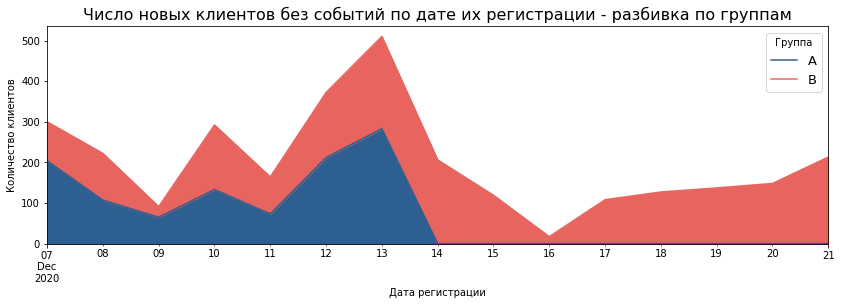

In [29]:
#график кол-ва клиентов с пустыми событиями по дню их рег-ции
palette = ['#2D5F91','#E8655F',]

no_event_user.plot.area(figsize = (14,4), color=palette)

plt.title('Число новых клиентов без событий по дате их регистрации - разбивка по группам', fontsize=16)
plt.xlabel('Дата регистрации')
plt.legend( labels=['A','B'], title='Группа', fontsize=13)
plt.ylabel('Количество клиентов');

Записи с незаполненным событием относятся к очень большому количеству клиентов - 3026  
и составляют почти 11% от всех записей теста recommender_system_test.  
До 13-12-2020 в каждую группу теста попадало пропорциональное число клиентов с пустым событием.  
После этой даты такие клиенты фиксируются только в группе В, здесь они пропали после 21-12-2020.

Можно предположить разные причиные такой ситуации - ошибки записи/чтения данных,   
влияние каких-либо активностей/изменений в работе магазина, ошибки в сборе информации при проведении теста.    

Данный тест проводился для анализа изменения метрик, которые рассчитываются  
на основе определенных событий: переход в корзину, покупка и т.д.  

Записи с пустым событем не дают информации для такого анализа, по-хорошему, их нужно удалить,  
так как никакого смысла они не содержат.  

Обработаем пропуски, чтобы они не мешали в дальнейшем анализе.  
В столбце 'события' пропуски заполним значением 'unknown'.  
В столбце 'дата-время события' - заполним датой регистрации, т.к. другой у нас нет.  

In [30]:
#заполнение пропумсков
df['event']    = df['event'].fillna('unknown')
df['event_dt'] = df['event_dt'].fillna(df['new_first_dt'] )

In [31]:
#вспомогательный стобец с выделенной датой
df['evnt_date'] = df['event_dt'].dt.date

**Вывод**  
После объединения данных выяснилось, что не для всех новых клиентов есть информация о событиях.  
Такие записи оставлены, пропуски обработаны.  

**Тест скомпроментирован большим количеством, почти 11%, 'мусорных' записей.**

## Оценка корректности проведения A/B теста  
2.1 Соответствие данных техническому заданию  
2.2 Совпадение теста по времени с маркетинговыми и другими активностями  
2.3 Аудитория теста:   
   - проверка пересечений с конкурирующим тестом  
   - проверка пользователей, участвующих в двух группах теста одновременно    
   - равномерность распределения пользователей по тестовым группам  
   - корректность формирования групп теста  

### Соответствие данных техническому заданию  

Техническое задание - далее ТЗ.  

**1.** Название теста: recommender_system_test  
**2.** Группы: А (контрольная), B (новая платёжная воронка)  

Есть записи с таким значением (изменен на recomend_sys) и разделение на 2 группы -  **соответствует ТЗ**.  

**3.** Дата запуска теста: 07-12-2020  
**4.** Дата остановки теста: 01-04-2021  
**5.** Дата остановки набора новых пользователей: 21-12-2020

In [32]:
print('Минимальная дата регистрации клиентов  ',df['new_first_dt'].min())
print('Минимальная дата событий               ',df['event_dt'].min())
print()
print('Максимальная дата регистрации клиентов',df['new_first_dt'].max())
print('Максимальная дата событий             ',df['event_dt'].max())
print()
print('Количество пропущенных дней теста     ',(datetime(2021, 1, 4).date() - max(df['evnt_date'])).days  )
print( )
print('Количество лишних дней набора в тест  ', (max(df['new_first_dt'].dt.date) - datetime(2020, 12, 21).date() ).days  )

print('Количество дней теста                 ', (max(df['event_dt'].dt.date) - min(df['new_first_dt'].dt.date) ).days  )

Минимальная дата регистрации клиентов   2020-12-07 00:00:00
Минимальная дата событий                2020-12-07 00:00:00

Максимальная дата регистрации клиентов 2020-12-23 00:00:00
Максимальная дата событий              2020-12-30 18:28:55

Количество пропущенных дней теста      5

Количество лишних дней набора в тест   2
Количество дней теста                  23


Дата запуска теста **соответствует ТЗ**.  

Дата остановки теста **не соответствует ТЗ** - меньше на 5 дней.  
Максимальная дата событий -  30-12-2020.  
Это говорит о том, не все клиенты успели 'прожить' 14 дней с момента регистрации.  
Неполное количество дней 'жизни' может исказить результаты теста.  

Дата остановки набора новых пользователей для теста **не соответствует ТЗ** - больше на 2 дня.  
Записи о клиентах, которые зарегистрировались после 21-12-2020 нужно удалить.  

In [33]:
df = df.query('new_first_dt <= "2020-12-21"')

**6.** Аудитория теста - 15% новых пользователей из EU: Доля новых клиентов из региона EU, принявших участие в тесте,  
от всех новых клиентов из EU, с датой регстрации по 21-12-2020 включительно.

In [34]:
#кол-во новых клиентов из ЕС, которые приняли участие в тесте  recomend_sys
test_eu = df.query('new_region == "eu" and ab_test == "recomend_sys" ')['user_id'].nunique()

#кол-во всех новых клиентов из ЕС с датой рег <= 21-12-2020
all_eu = new_users.query('new_region == "eu" and  new_first_dt <= "2020-12-21"')['user_id'].nunique()

In [35]:
print('Количество новых клиентов из Евросоюза, участвовавших в тесте:', test_eu )
print('Количество новых клиентов из Евросоюза:', all_eu )
print()
print ('Доля новых пользователей из Евросоюза', '{0:.1%}'.format(test_eu/all_eu )  )

Количество новых клиентов из Евросоюза, участвовавших в тесте: 6351
Количество новых клиентов из Евросоюза: 42340

Доля новых пользователей из Евросоюза 15.0%


Доля принявших участие в тесте клиентов из региона EU:  15% -  **соответствует ТЗ**.  

Исходя из ТЗ, аудитория теста - клиенты из Евросоюза, поэтому исключим из датасета клиентов из других регионов.

In [36]:
#оставляем только EU
df_eu = df.query('new_region == "eu"')

**7.** Ожидаемое количество участников теста: 6000  

In [37]:
print('Количество участников теста recommender_system_test:',\
      df_eu.query('ab_test == "recomend_sys" ')['user_id'].nunique()  )

Количество участников теста recommender_system_test: 6351


Число участников теста чуть больше ожидаемого, это значит, данный пункт **соответствует ТЗ**.  

**Вывод**  
**1.** Название теста: recommender_system_test -  **соответствует ТЗ.**  
**2.** Группы: А (контрольная), B (новая платёжная воронка) -  **соответствует ТЗ.**  
 
**3.** Дата запуска теста: 07-12-2020 -  **соответствует ТЗ.**  
**4.** Дата остановки теста: 01-04-2021 - **не соответствует ТЗ**, меньше на 5 дней.   
Максимальная дата событий -  30-12-2020.  Не все клиенты успели 'прожить' 14 дней с момента регистрации.  
Неполное количество дней 'жизни' может исказить результаты теста.  

**5.** Дата остановки набора новых клиентов: 21-12-2020 - **не соответствует ТЗ** - больше на 2 дня.  
Лишние записи удалены.  

**6.** Аудитория теста - 15%:  
Доля новых клиентов из региона EU с датой регистрации по 21-12-2020 включительно, принявших участие в тесте,  
от всех новых клиентов из EU, с датой регстрации по 21-12-2020 включительно -  **соответствует ТЗ.**  

**7.** Ожидаемое количество участников теста: 6000 - на данном этапе **соответствует ТЗ.**  

Из 7 пунктов **не соответствуют ТЗ** два:  
- Дата остановки теста  - данные невозможно скорректировать,  
- Дата остановки набора новых клиентов - данные скорректированы.

### Совпадение теста по времени с маркетинговыми и другими активностями  

Выделим данные об изучаемом тесте в отдельный датасет.

In [38]:
#все события теста recomend_sys
df_recom = df_eu.query('ab_test == "recomend_sys" ')

In [39]:
#дата начала теста
start_test = pd.to_datetime('2020-12-07')

#компании, которые пересекаются с тестом
inter_test_markt = marketing.query('start_dt >= @start_test') 
inter_test_markt

name        regions   start_dt  finish_dt
0    christmas_new year promo  eu, n_america 2020-12-25 2021-01-03
10  cis new year gift lottery            cis 2020-12-30 2021-01-07

Есть маркетинговое событие, которое пересекаются по времени и месту с тестом:   

- 'Christmas&New Year Promo' - для клиентов из Евросоюза и стран Сев. Америки.  

Изучим события, зафиксированные одновременно с этимой промоакцией.

In [40]:
#события теста recomend_sys, которые совпали по времени с промо
promo = df_eu[(df_eu['ab_test'] == "recomend_sys") & (df_eu['evnt_date'] >= inter_test_markt['start_dt'].min())]

In [41]:
print('Количество событий, которые совпали по времени с промоакциями:', len(promo)  )
print('Доля таких событий от всех событий теста:', '{0:.0%}'.format( len(promo) / len(df_recom) )  ) 

Количество событий, которые совпали по времени с промоакциями: 3164
Доля таких событий от всех событий теста: 12%


Значительная доля событий теста совпала с маркетинговой кампанией.

In [42]:
#значение для оси х
xticks = list(df_recom['evnt_date'].sort_values().unique())

#подписи для оси х
xtickslabels = list(df_recom['event_dt'].dt.strftime('%Y-%m-%d').str.replace('2020-12-','').sort_values().unique())

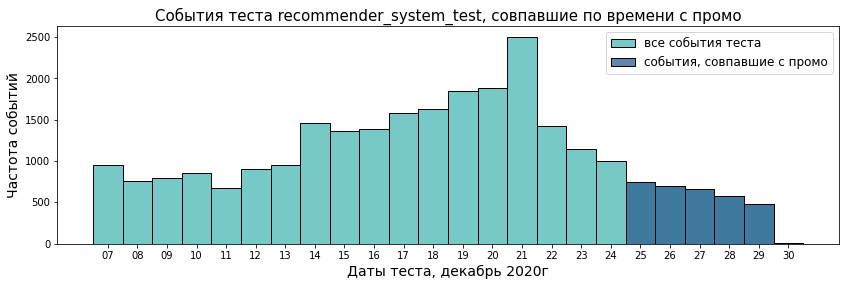

In [43]:
plt.figure(figsize=(14,4))
plt.title('Cобытия теста recommender_system_test, совпавшие по времени с промо',fontsize=15) 

plt.ylabel('Частота событий', fontsize=14)
plt.xlabel('Даты теста, декабрь 2020г',fontsize=14)
plt.xticks(xticks, xtickslabels, fontsize=10)

sns.histplot(df_recom['evnt_date'], bins=24,color ='#48B7B4', label ='все события теста')
sns.histplot(promo['evnt_date'],    bins=6, color ='#2D5F91', label ='события, совпавшие с промо')
plt.legend( fontsize=12);

Изучим влияние промоакции на активность клиентов.

In [44]:
#группируем по дате и группе теста, считаем кол-во записей
events = df_recom.groupby(['evnt_date','group']).agg({'user_id':'count'}).reset_index()

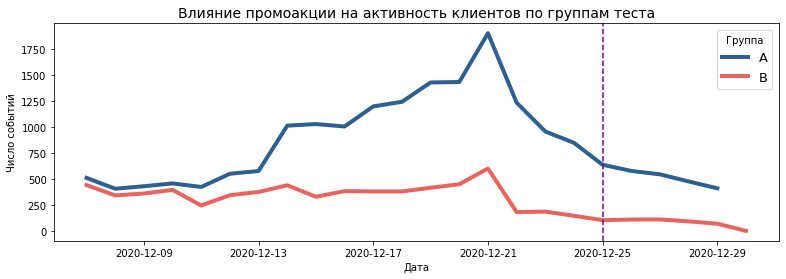

In [45]:
#график активности клиентов, попавших в тест - разделение по группам теста
palette = ['#2D5F91','#E8655F']

plt.figure(figsize=(13, 4))
plt.title('Влияние промоакции на активность клиентов по группам теста',fontsize=14 )

sns.lineplot(data=events, x='evnt_date', y='user_id', hue='group', linewidth=4, palette=palette)

plt.xlabel('Дата')
plt.ylabel('Число событий')
plt.axvline(x= pd.to_datetime('2020-12-25'), color='purple', linestyle='--')
plt.legend( labels=['A','B'],title='Группа', fontsize=13);

Максимум событий зафиксирован с 14-12-2020 по 22-12-2020.  
Во время промоакции, с 25-12-2020  по 30-12-2020, в обеих группах активность клиентов не увеличилась.  
Можно предположить, что промо не повлияло на действия пользователй.  
Поэтому удалять события, совпавшие по времени с промо, не будем.  

В целом, не очень правильно проводить  A/B тесты одновременно с другими активностями,  
такое наложение можеть исказить результаты.  

**Тест скомпроментирован проведением параллельно с маркетинговыми активностями.**

### Аудитория теста  
2.3.1 Проверка пересечений с конкурирующим тестом  
2.3.2 Проверка пользователей, участвующих в двух группах теста одновременно  
2.3.3 Горизонт анализа данных    
2.3.4 Равномерность распределения клиентов по группам теста  

#### Проверка пересечений с конкурирующим тестом
Уже на предыдущих этапах выяснено, что в данных есть записи о двух A/B тестах.  
Узнаем число клиентов, попавших в оба теста, в объединенном датасете (без клиентов, удаленных по дате регистрации).

In [46]:
#users recommender_system_test
recom_users = df_recom['user_id'].unique()

#users recomend_sys
interface_users = df_eu.query('ab_test != "recomend_sys" ')['user_id'].unique()

cross_users = set(recom_users).intersection(set(interface_users)    )
print('Количество уникальных клиентов, попавших в оба теста:', len(cross_users)  )

#события recomend_sys клиентов, попавших в оба теста
df_cross = df_recom.query('user_id in @cross_users')

print('Доля событий клиентов, попавших в оба теста, от всех всех событий теста recommender_system_test:',\
      '{0:.1%}'.format( len(df_cross) / len(df_recom) )  ) 

Количество уникальных клиентов, попавших в оба теста: 1602
Доля событий клиентов, попавших в оба теста, от всех всех событий теста recommender_system_test: 25.1%


Почти четверть событий изучаемого теста принадлежит клиентам, попавшим в другой A/B тест.  
Про второй тест нет инофрмации и ТЗ, поэтому невозможно точно оценить его влияние на recommender_system_test.  

Клиентов recommender_system_test, попавших в группу А recomend_sys, можно оставить,  
на них конкурирующий тест не повлиял - т.е., в обоих тестах эти клиенты не видели никаких изменений в магазине.  

interface_eu мог повлиять на исследуемый тест,  
если распределение участников группы В interface_eu не было равномерным между группами recommender_system_test.

In [47]:
interface_b = df_eu.query('ab_test == "interface_eu" and group == "b"')['user_id'].unique()
                          
print('Распределиение участников группы В теста interface_eu между группами теста recommender_system_test')

df_recom.query('user_id in @interface_b').groupby('group').agg({'user_id':'nunique'}).reset_index()

Распределиение участников группы В теста interface_eu между группами теста recommender_system_test


group  user_id
0     a      439
1     b      344

Участники группы В из теста interface_eu примерно равномерно распределены между группами recommender_system_test.  
То есть, влияние interface_eu на обе группы теста recommender_system_test примерно одинаково,  
поэтому клиентов, попавших в оба теста можно не удалять.


В целом, совершенно неправильно проводить несколько  A/B тестов одновременно,  
из-за их влияния друг на друга они будут показывать нерелевантные результаты.  

**Тест скомпроментирован проведением параллельно с другим тестом.**

#### Проверка клиентов, попавших в обе группы теста одновременно

In [48]:
users_a = df_recom.query('group == "a"')['user_id'].unique()
users_b = df_recom.query('group != "a"')['user_id'].unique()

cross_users_ab = set(users_a).intersection(set(users_b)    )

print('Количество уникальных клиентов, попавших в обе группы теста:', len(cross_users_ab)  )

Количество уникальных клиентов, попавших в обе группы теста: 0


Пересечений по группам нет, в этом тест проведен правильно.  

#### Горизонт анализа данных  

Нужно проверить, что в данных есть только клиенты, которые успели 'дожить' до выбранного горизонта,  
или, наоборот, не успели 'прожить' больше.  
Если проигнорировать момент и горизонт анализа, расчеты будут неверным из-за пробелов в данных.  

Для проверки нужно вычислить:  
- горизонт анализа (максимальный лайфтайм клиентов), известен из ТЗ - 14 дней с момента регистрации,  


- момент анализа - в данном случае это максимальная дата событий,  


- максимально возможную дату привлечения клиентов = момент анализа (max дата события) - горизонт анализа (14 дней),  


- лайфтайм каждого события = дата события - дата регистрации клиента.  

In [49]:
#горизонт анализа из ТЗ
horizon = 14

#момент анализа
moment = df_recom['evnt_date'].max()

#максимально дата привлечения, 1 отнимается потому что лайфтайм считается с нуля
last_aquis_day = moment - timedelta(days = horizon - 1)

print('Горизонт анализа:', horizon, 'дней')
print('Момент анализа:', moment)
print('Максимально возможный день привлечения клиентов:', last_aquis_day)

Горизонт анализа: 14 дней
Момент анализа: 2020-12-30
Максимально возможный день привлечения клиентов: 2020-12-17


In [50]:
#расчет лайфтайма каждого события
df_recom['lifetime'] = (df_recom['event_dt']  - df_recom['new_first_dt']).dt.days.astype('int')

Удалим все записи, где лайфтайм больше горизонта анализа (больше 14 дней).  
Рассмотрим, как какое количество событий совершалось в каждый лайфтайм теста.

In [51]:
df_recom = df_recom.query('lifetime <= 13')

In [52]:
event_by_lifetime = df_recom.groupby('lifetime', as_index=False).agg({'event':'count'})

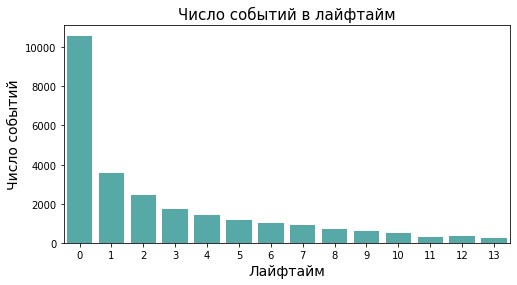

In [53]:
plt.figure(figsize=(8,4))
plt.title('Число событий в лайфтайм',fontsize=15)
sns.barplot(data=event_by_lifetime, x='lifetime', y='event', color ='#48B7B4')

plt.ylabel('Число событий', fontsize=14)
plt.xlabel('Лайфтайм',fontsize=14);

Большая часть всех событий была совершена в первый день 'жизни' клиентов.  
Полученный результат означает, что воронка формируется раньше, чем горизонт анализа.  
Это важно, поскольку  тест остановился раньше запланированного, и не все клиенты успели 'прожить' все 14 дней.  

Если мы уменьшаем выборку, то ее может быть в итоге недостаточно для получения корректных результатов.  
Поэтому клиентов, дата регистрации которых больше максимальной даты привлечения,  
(т.е., тех, кто 'прожил' меньше 14 дней) оставляем. 

#### Равномерность распределения клиентов по группам теста

In [54]:
users_a = df_recom.query('group == "a"')['user_id'].unique()
users_b = df_recom.query('group != "a"')['user_id'].unique()

print('Количество клиентов в группе А:', len(users_a)  ) 
print('Количество клиентов в группе B:', len(users_b)  )

Количество клиентов в группе А: 3634
Количество клиентов в группе B: 2717


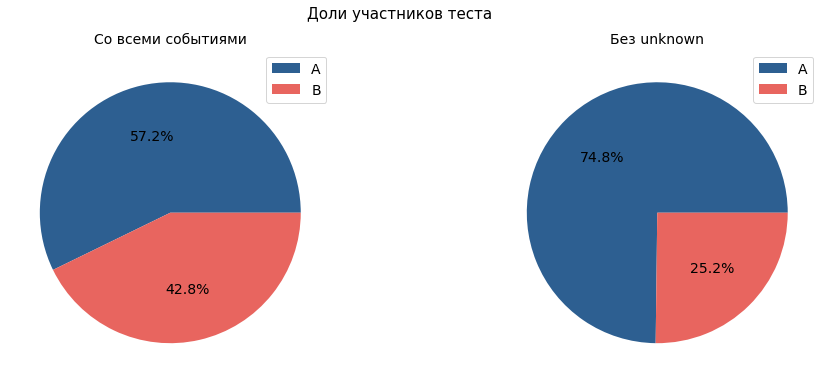

In [55]:
fig = plt.figure(figsize=(16,6))
plt.suptitle('Доли участников теста',fontsize=15)

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Со всеми событиями',fontsize=14)

ax1 = plt.pie(df_recom.groupby('group', as_index=False).agg({'user_id':'nunique'})['user_id'], autopct = '%0.1f%%'
        ,textprops = {'fontsize': 14}, colors=palette)

plt.legend(labels= ['А', 'В'],fontsize=14 )

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Без unknown',fontsize=14)

ax2 = plt.pie(df_recom.query('event !="unknown" ')
                .groupby('group', as_index=False).agg({'user_id':'nunique'})['user_id']
        ,autopct = '%0.1f%%', textprops = {'fontsize': 14}, colors=palette)

plt.legend(labels= ['А', 'В'],fontsize=14 );

In [56]:
print('Относительное различие количества клиентов в группах:', '{0:.0%}'.format( 1 - 42.8 /57.2 )  ) 

Относительное различие количества клиентов в группах: 25%


Относительное различие количества клиентов в 25% - это очень много.  
Если удалить клиентов с неизвестным событием, разница становится критически большой.  

При этом, даже совсем небольшая разница в долях групп искажает результаты теста.  
**Деление на группы теста по размеру некорректно.**

### Вывод по корректности проведения теста  

1. Почти 11% записей в тесте не содержат информации о событиях, совершенных клиентами.  
   
   
2. Тест **не** соответствует 2 пунктам ТЗ из 7:
  - Дата остановки теста - не все клиенты успели 'прожить' 14 дней с момента регистрации,  
    данные невозможно скорректировать,
  - Дата остановки набора новых клиентов - данные скорректированы.  


3. 12% событий теста совпало по времени с маркетинговой кампанией.  


4. 25.1% событий теста совершено клиентами, попавшими в другой тест, проводившийся параллельно.  


5. В исходных данных не учтены горизонт анализа данных.  


6. Относительное различие числа участников в группах теста - 25%, группа А - 3634, группа В - 2717.    


**Тест recommender_system_test проведен некорректно, его результатам нельзя доверять.**  


## Исследовательский анализ данных  
3.1 Одинаково ли число событий на пользователя в выборках   
3.2 Распределение числа событий на дату в выборках  
3.3 Изменение конверсии на разных этапах воронки в выборках  
3.4 Особенности данных, которые нужно учесть, прежде чем приступать к A/B-тестированию  

### Одинаково ли число событий на пользователя в выборках 

In [57]:
#сгруппируем события по id пользователя, считаем кол-во записей
evnt_user = df_recom.query('event !="unknown"').groupby(['user_id']).agg({'group':'first','event': 'count'})

In [58]:
#значение для оси х
xticks_e = list(range(1, evnt_user['event'].max())  )

In [59]:
#evnt_user.query('group == "b"')['event'].max()

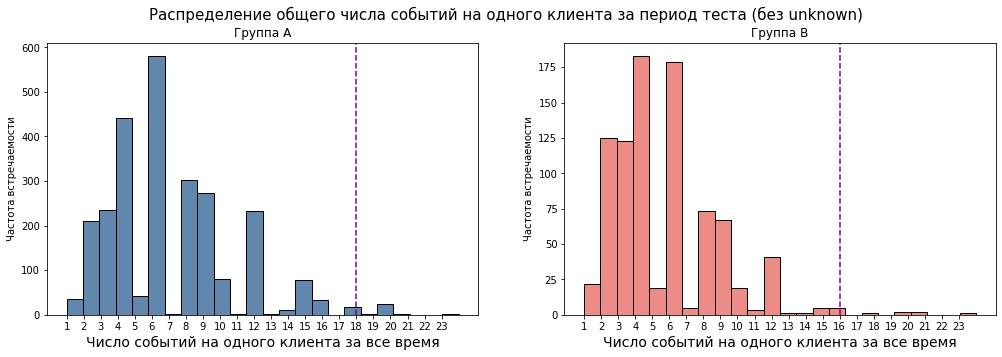

In [60]:
#гистограммы распределения числа событий на клиента за весь период
fig = plt.figure(figsize=(17,5))
plt.suptitle('Распределение общего числа событий на одного клиента за период теста (без unknown)',fontsize=15)

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Группа А')
ax1.set_ylabel('Частота встречаемости')
ax1.set_xlabel('Число событий на одного клиента за все время',  fontsize=14)
plt.xticks(xticks_e, xticks_e, fontsize=10)         
plt.axvline(x= evnt_user.query('group == "a"')['event'].quantile(0.99), color='purple', linestyle='--')

sns.histplot(evnt_user.query('group == "a"')['event'],bins=24,  color ='#2D5F91',label ='A', ax=ax1)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Группа В')
ax2.set_ylabel('Частота встречаемости')
ax2.set_xlabel('Число событий на одного клиента за все время',  fontsize=14)
plt.xticks(xticks_e, xticks_e, fontsize=10)
plt.axvline(x= evnt_user.query('group == "b"')['event'].quantile(0.99), color='purple', linestyle='--')

sns.histplot(evnt_user.query('group == "b"')['event'],bins=24,  color ='#E8655F',label ='B', ax=ax2);

In [61]:
mean_a = evnt_user.query('group == "a" and event <= event.quantile(0.99)')['event'].mean()
mean_b = evnt_user.query('group == "b" and event <= event.quantile(0.99)')['event'].mean()

print('Среднее значение общего числа событий на клиента за время теста для группы А:', int(mean_a))
print('Среднее значение общего числа событий на клиента за время теста для группы В:', int(mean_b))

Среднее значение общего числа событий на клиента за время теста для группы А: 6
Среднее значение общего числа событий на клиента за время теста для группы В: 5


Среднее значение вычислялось с отбрасыванием аномальных по 99-му персентилю.  
По среднему значению общего количества событий у групп почти нет разницы.

In [62]:
#число уникальных событий на каждого клиента
unic = df_recom.query('event !="unknown"').groupby(['group', 'user_id']).agg({'event':'nunique'}).reset_index()

In [63]:
xticks_u = list(unic['event'].sort_values().unique())

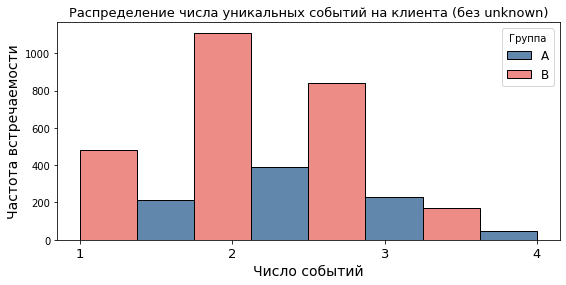

In [64]:
palette = ['#E8655F','#2D5F91',]
plt.figure(figsize=(9,4))
plt.title('Распределение числа уникальных событий на клиента (без unknown)',fontsize=13) 

plt.ylabel('Частота встречаемости', fontsize=14)
plt.xlabel('Число событий',fontsize=14)
plt.xticks(xticks_u, xticks_u, fontsize=13)

sns.histplot(unic, x='event', hue='group', bins=unic['event'].max(), multiple='dodge', palette=palette)
plt.legend(labels=['A','B'], title='Группа', fontsize=12);

In [65]:
median_evn_a = unic.query('group == "a" ')['event'].median()
median_evn_b = unic.query('group == "b"')['event'].median()

print('Среднее значение числа уникальных событий на клиента за время теста для группы А:', int(median_evn_a))
print('Среднее значение числа уникальных событий на клиента за время теста для группы В:', int(median_evn_b))

Среднее значение числа уникальных событий на клиента за время теста для группы А: 2
Среднее значение числа уникальных событий на клиента за время теста для группы В: 2


Среднее значение уникальных событий на клиента равно в группах.

In [66]:
#кол-во уник клиентов по событиям
event = (df_recom.query('event !="unknown"')
                 .groupby(['group', 'event']).agg({'user_id':'nunique'}).sort_values(by='user_id').reset_index()  )
event.columns = ['group','event','user_cnt']

In [67]:
fig = px.bar(event, y='user_cnt',x='event', text='user_cnt',  color =event['group'].map({'a':"A",'b':"B"}), 
             width=800, height=450, color_discrete_sequence=palette)

fig.update_layout(title={'text': 'Число уникальных клиентов на событие за весь период теста (без unknown)'
                         ,'y':0.95, 'x':0.5,  'xanchor': 'center', 'yanchor': 'top'})

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor':'rgba(0, 0, 0, 0)'}
                  ,xaxis_showgrid=False, yaxis_showgrid=False)

fig.update_traces(textposition='inside',textfont_color='black')

fig.update_layout(yaxis_title = 'Число клиентов', xaxis_title = 'Событие', barmode='group'
                  ,legend={'title_text':'Группа'})
fig.show()

Ожидаемо наибольшее число клиентов совершило событие логин.  
Собыие 'заказ' и 'корзина' совершило практически одинаковое число клиентов в обеих группах -  
эти события совершались меньше всего, что тоже ожидаемо.    
По группам количество клиентов на событие выглядят пропорционально.

In [68]:
evnt = event.pivot_table(index='event', columns='group', values='user_cnt')

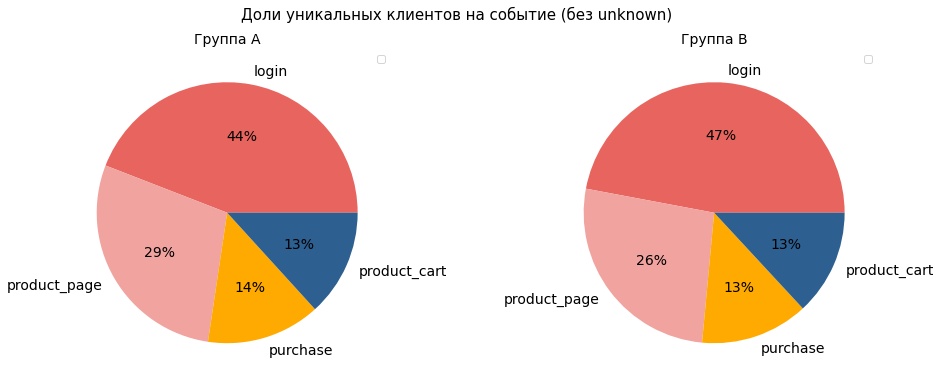

In [69]:
palette_pie = ['#E8655F','#F1A39F','#FFAA00', '#2D5F91','#819FBD']

fig = plt.figure(figsize=(16,6))
plt.suptitle('Доли уникальных клиентов на событие (без unknown)',fontsize=15)

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Группа А',fontsize=14)
(evnt.sort_values(by='a', ascending=False)
     .plot.pie(y='a', autopct = '%0.0f%%', textprops = {'fontsize': 14}, colors=palette_pie, ax=ax1))

ax1.set_ylabel('')  
ax1.legend(labels='');

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Группа В',fontsize=14)
(evnt.sort_values(by='b', ascending=False)
     .plot.pie(y='b', autopct = '%0.0f%%', textprops = {'fontsize': 14}, colors=palette_pie, ax=ax2))

ax2.set_ylabel('') 
ax2.legend(labels='');

Всего зафиксировано 4 события:     - логин,    - страница товара,  - корзина,  - заказ.  
События имеют похожие доли в обеих группах.

### Распределение  событий на день в выборках  

In [70]:
#группируем по дате и группе, считаем кол-во записей
events = df_recom.groupby(['evnt_date','group']).agg({'user_id':'count'}).reset_index()

In [71]:
#значение для оси х
xticks = list(df_recom['event_dt'].dt.strftime('%Y-%m-%d').sort_values().unique()) 
#подписи для оси х
xtickslabels = (list(df_recom['event_dt'].dt.strftime('%Y-%m-%d').str.replace('2020-12-','').sort_values().unique())   )

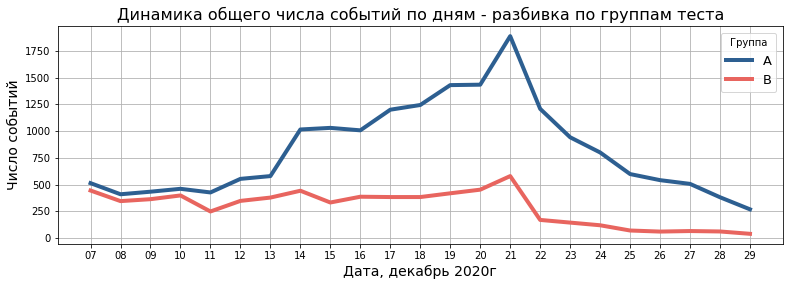

In [72]:
#график - динамика общего числа событий
palette = ['#2D5F91','#E8655F']

plt.figure(figsize=(13, 4))
plt.title('Динамика общего числа событий по дням - разбивка по группам теста', fontsize=16)

sns.lineplot(data=events, x='evnt_date', y='user_id', hue='group', linewidth=4, palette=palette)

plt.xlabel('Дата, декабрь 2020г', fontsize=14)
plt.ylabel('Число событий',fontsize=14)
plt.legend( labels=['A','B'],title='Группа', fontsize=13)
plt.xticks(xticks, xtickslabels, fontsize=10)
plt.grid();

Наибольшую активность клиенты проявили в период с 14-12-2020 по 18-12-2020.  
Скорее всего, это период бума покупок перед католическим Рождеством и Новым годом.  
После 20-12-2020 активность резко уменьшилась.   

По группам распределение выглядит пропорционально, большая активность в группе А, обусловлена,  
вероятно, меньшим размером экспериментальной группы.

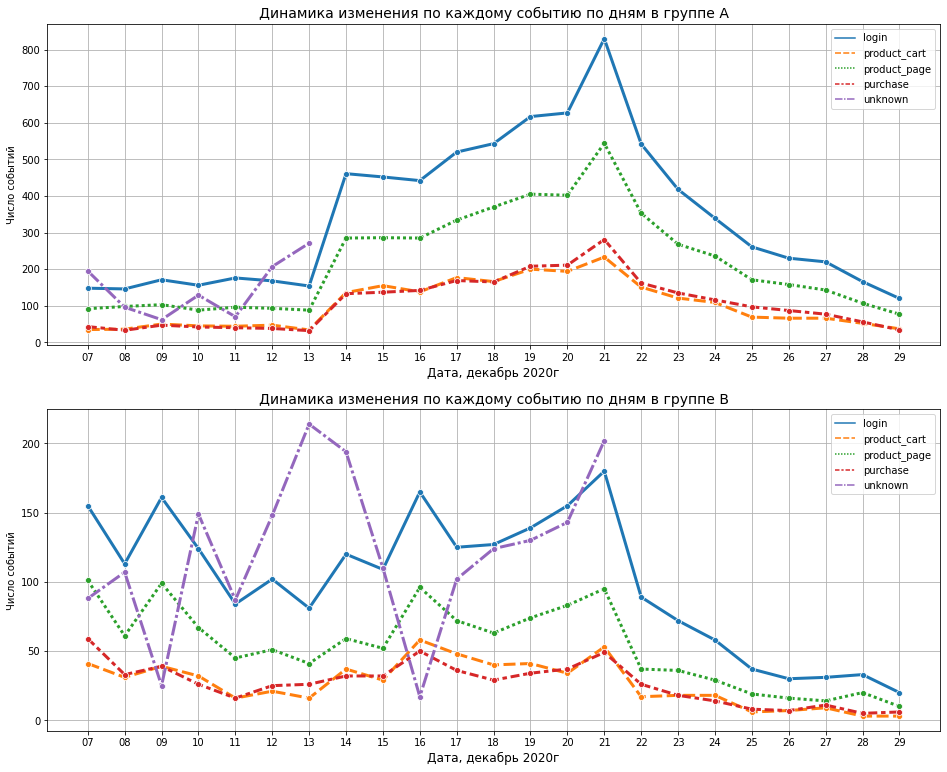

In [73]:
#график - динамика по каждому событию
plt.figure(figsize=(16, 13))

ax1 = plt.subplot(2, 1, 1)
ax1 = sns.lineplot(data=df_recom.query('group == "a"')
                                .pivot_table(index='evnt_date', columns='event',values='user_id', aggfunc='count')
                   , marker='o', linewidth=3)
plt.title('Динамика изменения по каждому событию по дням в группе А', fontsize=14)
plt.ylabel('Число событий')
plt.xlabel('Дата, декабрь 2020г',fontsize=12)
plt.grid()
plt.xticks(xticks, xtickslabels, rotation=0)
plt.legend(loc='upper right')

ax2 = plt.subplot(2, 1, 2)       
ax2 = sns.lineplot(data=df_recom.query('group == "b"')
                                .pivot_table(index='evnt_date', columns='event',values='user_id', aggfunc='count')
                   , marker='o', linewidth=3)
plt.title('Динамика изменения по каждому событию по дням в группе В', fontsize=14)
plt.ylabel('Число событий')
plt.xlabel('Дата, декабрь 2020г',fontsize=12)
plt.grid()
plt.xticks(xticks, xtickslabels, rotation=0)
plt.legend(loc='upper right');

Динамика изменения числа каждого события по группам полностью повторяет предыдущие графики  
по периоду максимальной активности  
и по долям между событиям, т.е., например, больше всего совершено события 'логин'.  

Исключение составляет график события 'неизвестно': в группе А ошибка записи события исчезла после 13-12-2020,  
а в группе В - только после 21-12-2020.

In [74]:
user_mean = (df_recom.query('event !="unknown"')
                    .groupby(['group','evnt_date','user_id'], as_index=False)['user_id'].count()  )

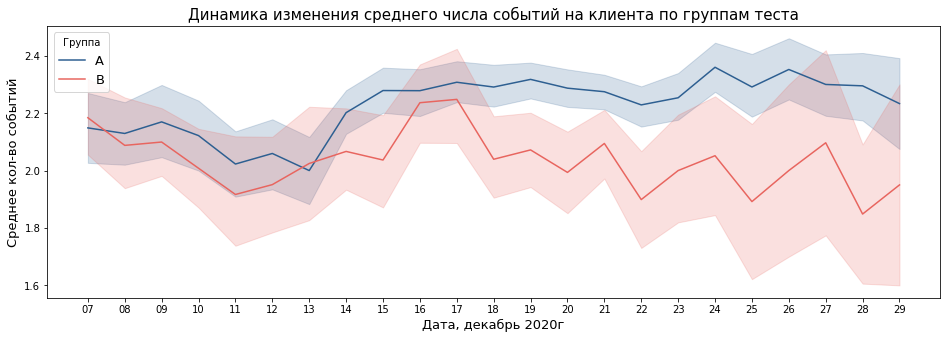

In [75]:
plt.figure(figsize=(16,5))

plt.title('Динамика изменения среднего числа событий на клиента по группам теста', fontsize=15)
plt.xlabel('Дата, декабрь 2020г', fontsize=13)
plt.ylabel('Среднее кол-во событий', fontsize=13)

sns.lineplot(data=user_mean, x='evnt_date', y='user_id',  hue='group',palette=palette, estimator=np.mean)

plt.legend(labels=['A','B'],title='Группа', fontsize=13, loc='upper left')
plt.xticks(xticks, xtickslabels, rotation=0, fontsize=10);

**Вывод**  
Среднее общего числа событий на клиента за время теста для групп почти неразличимо: 6-5.  
Среднее число уникальных событий на клиента равно 2 в обеих группах.  
По группам число клиентов на уникальное событие выглядят пропорционально.  

Наибольшую активность клиенты проявили в период с 14-12-2020 по 18-12-2020, перед праздниками.  
По группам распределение выглядит пропорционально, большая активность в группе А, обусловлена,  
вероятно, разницей в размерах между группами.

### Изменение конверсии на разных этапах воронки в выборках  

Неизвестные события бесполезны при изучении конверсии, удалим их.

In [76]:
df_fun = df_recom.query('event != "unknown"')                               #очистим датасет от мусорных записей
print('Количество клиентов с заполненным событием', df_fun['user_id'].nunique()  )

Количество клиентов с заполненным событием 3481


После удаления клиентов с незаполненным событием, число участников теста сократилось почти вдвое.  
На данном этапе требование ТЗ по числу аудитории тест не соблюдается.

**Общая конверсия - число и доля клиентов (от первого шага) по шагам воронки в разрезе групп**  

In [77]:
a_cnt = df_fun.query('group =="a"')['user_id'].nunique()
b_cnt = df_fun.query('group =="b"')['user_id'].nunique()

In [78]:
#группируем по событию, группе, считаем кол-во уник клиентов
share = (df_fun.groupby(['event','group'], as_index=False).agg({'user_id':'nunique'})  )

#переворачиваем: индекс - событие, колонки - группы теста, значения - кол-во клиентов
share = share.pivot_table(index='event', columns='group',values='user_id').reset_index()
share = share.rename_axis(None, axis=1)

In [79]:
#отдельные датасеты по группам
new_order = ['login', 'product_page', 'product_cart', 'purchase']

share_a = share[['event', 'a']].set_index('event').reindex(new_order).reset_index()

share_b = share[['event', 'b']].set_index('event').reindex(new_order).reset_index()

In [80]:
#доля на шаге воронки от  первого шага
share_a['share_a'] =  (share_a['a'] / share_a.loc[share_a['event']=='login', 'a'].values[0] *100).round(1)

#конверсия в шаг - % изменение между текущим и предыдущим эл-ом
share_a['step_share_a'] = share_a['a'].pct_change().apply(lambda x: (1 + x)*100).round(1)

#разница долей, типа, уменьшилось на 20%
share_a['step_diff_a'] = share_a['a'].pct_change().apply(lambda x: abs(x)).round(2)

In [81]:
#для заполнения nan первой строки - конверсия в шаг от первого шага
#login_step_a =(share_a.loc[share_a['event']=='login', 'a']  / a_cnt*100).round(1)

#для заполнения nan первой строки - разница долей, типа, уменьшилось на 20%
#login_dif_a = 1 -(share_a.loc[share_a['event']=='login', 'a'] / a_cnt ).round(3)

share_a.loc[share_a['event']=='login', 'step_share_a'] = 100
share_a.loc[share_a['event']=='login', 'step_diff_a']  = 0

In [82]:
#то же самое для В
share_b['share_b'] =  (share_b['b'] / share_b.loc[share_b['event']=='login', 'b'].values[0] *100).round(1)

share_b['step_share_b'] = share_b['b'].pct_change().apply(lambda x: (1 + x)*100).round(1)

share_b['step_diff_b'] = share_b['b'].pct_change().apply(lambda x: abs(x)).round(2)

In [83]:
#то же самое для В
#login_step_b = (share_b.loc[share_b['event']=='login', 'b']  / b_cnt*100).round(1)

#login_dif_b = 1 -(share_b.loc[share_b['event']=='login', 'b'] / b_cnt).round(3)

share_b.loc[share_b['event']=='login', 'step_share_b'] = 100
share_b.loc[share_b['event']=='login', 'step_diff_b']  = 0

In [84]:
convers = share_a.merge(share_b, how='outer', left_on='event', right_on='event')

In [85]:
convers

event     a  share_a  step_share_a  step_diff_a    b  share_b  \
0         login  2604    100.0         100.0         0.00  876    100.0   
1  product_page  1685     64.7          64.7         0.35  493     56.3   
2  product_cart   782     30.0          46.4         0.54  244     27.9   
3      purchase   833     32.0         106.5         0.07  249     28.4   

   step_share_b  step_diff_b  
0         100.0         0.00  
1          56.3         0.44  
2          49.5         0.51  
3         102.0         0.02

In [86]:
fig = make_subplots(rows=1, cols=2, specs=[[{"secondary_y": False}, {"secondary_y": True}] ]
                    ,column_widths=[0.63, 0.37]  )

fig.add_trace(go.Funnel(x=convers['a'], y=convers['event'], name='Группа А'
                        ,marker_color='#2D5F91', textinfo='value+percent initial'),  row=1, col=1
                        ,secondary_y=False)

fig.add_trace(go.Funnel(x = convers['b'], y=convers['event'], name='Группа В'
                        ,marker_color='#E8655F', textinfo='value+percent initial'),  row=1, col=2
                        ,secondary_y=True)

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor':'rgba(0, 0, 0, 0)'}
                  ,xaxis_showgrid=False, yaxis_showgrid=False)

fig.update_layout(title={'text': 'Общая конверсия по группам (от числа клиентов на первом шаге)'
                         ,'y':0.88, 'x':0.5,'xanchor': 'center', 'yanchor': 'top'})
fig.update_traces(textfont_color='black')
fig.show()

In [87]:
max_loss_step_a = convers.loc[convers['step_diff_a'].idxmax()]['event']              #шаг, с которого теряется max
max_loss_val_a = convers.loc[convers['step_diff_a'].idxmax()]['step_diff_a']         #max разница

payment_a = convers.iloc[-1]['a'] / convers.iloc[0]['a']           #событие заказ - последняя стр

max_loss_step_b = convers.loc[convers['step_diff_b'].idxmax()]['event']         
max_loss_val_b = convers.loc[convers['step_diff_b'].idxmax()]['step_diff_b']      

payment_b = convers.iloc[-1]['b'] / convers.iloc[0]['b']

In [88]:
print('При переходе к событию', max_loss_step_a,\
      'в группе А теряется больше всего клиентов: {:.0%}.'.format(max_loss_val_a) )
print('От первого события до оплаты доходят {:.1%} от общего числа клиентов из группы А.'.format(payment_a))
print()
print('При переходе к событию', max_loss_step_b,\
      'в группе В теряется больше всего клиентов: {:.0%}.'.format(max_loss_val_b) )
print('От первого события до оплаты доходят {:.0%} от общего числа клиентов из группы В.'.format(payment_b))

При переходе к событию product_cart в группе А теряется больше всего клиентов: 54%.
От первого события до оплаты доходят 32.0% от общего числа клиентов из группы А.

При переходе к событию product_cart в группе В теряется больше всего клиентов: 51%.
От первого события до оплаты доходят 28% от общего числа клиентов из группы В.


Целевое действие воронки событий - заказ.  
Расположив в логическом прорядке шаги воронки, видим, что доля переходов в заказ больше доли предыдущего шага - корзины.  
Можно сделать вывод, что в магазине есть возможность быстрого заказа, без попадания в корзину,  
и/или покупки со сторонних площадок.

Клиенты из группы B чуть хуже конвертируются на всех этапах воронки.  
Самая большая разница между группами по общей конверсии на шаге 'просмотр товара': 65% в группе А, против 56% в группе В.

**Конверсия в шаг - доли клиентов, проходящих на следующий шаг (от числа на предыдущем)**  

In [89]:
fig = go.Figure()
fig.add_trace(go.Funnel(x=convers['step_share_a'], y=convers['event'], name='Группа А'
                        ,marker_color='#2D5F91', textinfo='value')  )

fig.add_trace(go.Funnel(x = convers['step_share_b'], y=convers['event'], name='Группа В'
                        ,marker_color='#E8655F', textinfo='value')   )

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor':'rgba(0, 0, 0, 0)'}
                  ,xaxis_showgrid=False, yaxis_showgrid=False, width=800, height=450)

fig.update_layout(title={'text':'Конверсия в шаг по группам, %', 'y':0.85, 'x':0.5,'xanchor':'center','yanchor':'top'})
fig.update_traces(textfont_color='black')
fig.show()

Конверсия в шаг со страницы товара в корзину чуть лучше у группы В, по остальным шагам лидирует группа А.  
Конверсия в шаг между корзиной и заказом  106.5% у группы А и  102% у группы В,  
говорит о том, что часть клиентов совершает заказ минуя корзину.  

Найти реальную конверсию (для этих данных) по шагам: товар-корзина, товар-заказ, корзина-заказ, невозможно,  
т.к. нельзя однозначно сказать, какое действие после просмотра товара совершил клиент.

**Вывод**  
Группа А показывает лучшую конверсию, чем экспериментальная: 32% клиентов против 28% дошли от первого события до заказа.  

Больше всего клиентов теряется на переходе со страницы товара к просмотру корзины: у группы В 51%, у группы А 54%.  

Число событий 'заказ' чуть больше, чем 'просмотр корзины' внутри каждой группы, скорее всего,  
заказ можно совершить не заходя в корзину и/или с другой площадки.  
В данных нет деталей на этот счет, поэтому невозможно точно рассчитать  
конверсию на шагах 'просмотр товара', 'корзина', 'заказ' для полной воронки событий.

### Особенности данных, которые нужно учесть, прежде чем приступать к A/B-тестированию  

- Генеральная совокупность не содержит аномалий и выбросов.    
- Деление трафика работает безошибочно:  
      попавший в одну из групп клиент остаётся в ней до конца теста,  
      пользователи распределились между сегментами равномерно,
      структура трафика однородна.  
      
- Данные отправляются в системы аналитики корректно.  
- Учитываются  маркетинговые и другие активности, сезонные и общие события.  
- Выборка достаточна по размерам, чтобы избежать ошибки II рода.    
- Длительность теста достаточна, чтобы избежать 'проблемы подглядывания'.  


- Для принятия решения используется не только относительное изменение, но и проверка статистической значимости.  
- Для множественных сравнений применяются методы корректировки уровня значимости  
   для снижения групповой вероятности ошибки I рода.

## Оценка результатов A/B тестирования  
4.1  Анализ результатов теста  
4.2 Проверка статистической разницы долей z-критерием  

### Анализ результатов теста 

Согласно ТЗ, ожидаемый эффект от улучшенной рекомендательной системы:  
за 14 дней с момента регистрации клиентов каждая метрика улучшится не менее, чем на 10%:  

    конверсии в просмотр карточек товаров — событие product_page
    просмотры корзины — событие product_cart
    покупки — событие purchase.  
    
Расчитаем относительную разницу конверсии в группе В к группе А, по формуле:  
(конверсия В / конверсия А - 1)*100.

In [90]:
convers['b_a_share'] = ((convers['share_b'] /convers['share_a']).round(2) - 1)*100

In [91]:
convers['b_a_step_share'] = ((convers['step_share_b'] /convers['step_share_a']).round(2) - 1)*100

In [92]:
convers

event     a  share_a  step_share_a  step_diff_a    b  share_b  \
0         login  2604    100.0         100.0         0.00  876    100.0   
1  product_page  1685     64.7          64.7         0.35  493     56.3   
2  product_cart   782     30.0          46.4         0.54  244     27.9   
3      purchase   833     32.0         106.5         0.07  249     28.4   

   step_share_b  step_diff_b  b_a_share  b_a_step_share  
0         100.0         0.00        0.0             0.0  
1          56.3         0.44      -13.0           -13.0  
2          49.5         0.51       -7.0             7.0  
3         102.0         0.02      -11.0            -4.0

**Вывод**  
Внедренные изменения себя не оправдали. Все метрики вместо увеличения понизились.  
Хуже всего изменилась конверсия события 'просмотр товара' - она уменьшилась на 13%.  

Но только на основе относительного изменения принимать решения нельзя, нужно также  
проверить статистическую значимость различий в долях конверсии.

### Проверка статистической разницы долей z-критерием  
Проверки о равенстве долей сделаем с помощью Z-теста пропорций для двух независимых выборок  
Нулевая гипотеза в этом тесте утверждает равенство долей, т.е. что различий в пропорциях нет;  
альтернативная — что такие различия есть.  

In [93]:
#Функция проводит z-тест о равенстве долей для двух выборок
#Параметры:        df                           - датастет с группированными по группам и событиям данными   
#                  loop_col                     - название колонки с событиями
#                  group_1_name, group_2_name   - названия колонок, одновременно идентификаторы выборок
#                  gr1_size, gr2_size           - размер выборок (кол-во пользователей)
#                  alpha                        - уровень стат. значимости
#                  custom_evnt                  - список с выборочными событиями
#
def z_test(df, loop_col, group_1_name, group_2_name, gr1_size, gr2_size, alpha, custom_evnt=[]):
    
    cntr = 0                            #счетчик кол-ва проверок
     
    if not custom_evnt:                                         #isinstance(loop_col, list):
        events = list(df[loop_col])          
    else:
        events = custom_evnt

    bonferr_alph = alpha/len(events)
    
    print(events)
    print('\033[1m','         Группы:    ', group_1_name,'    ', group_2_name, '\033[0m')
    print('Уровень статистической значимости с поправкой Бонферрони:', '{0:.3%}'.format(bonferr_alph )  )
    print()
    for evnt in events:
    
        share_1 = df[df[loop_col]== evnt][group_1_name].values[0]
        share_2 = df[df[loop_col]== evnt][group_2_name].values[0]
           
        successes = np.array([share_1, share_2])
        trials    = np.array([gr1_size, gr2_size])
    
        p1 = successes[0]/trials[0]         #пропорция успехов в первой группе
        p2 = successes[1]/trials[1]         #пропорция успехов во второй группе

        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) #пропорция успехов в комб датасете
        diff = p1 - p2                 #разница пропорций в датасетах

#считаем статистику в стд откл стандартного нормального распр
        z_value = diff / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))    
        distr = st.norm(0, 1)                      #стд норм распределение (средн 0, ст.откл 1)
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('\033[1m', '         Доля события ', evnt,'\033[0m')
        print('z-статистика:', '{:.2f}'.format(z_value),'        p-value:', '{0:.3%}'.format(p_value)   )
            
        if p_value < bonferr_alph:
            print('Отвергаем гипотезу Н0: между долями групп есть значимая разница')
        else:
            print('Не отвергаем гипотезу Н0, нет статистической разницы между долями групп')   
        print()
        print()
        
        cntr +=1
        
    print('Количество проверок:','\033[1m', cntr,'\033[0m')

**Проверка статистической достоверности отличий между А/В-группами по долям событий**  

Гипотеза для проверки А/В-групп теста:  
**H0**: Статистически значимых различий в доле контрольной и экспериментальной групп нет (доли равны).  
**H1**: Статистически значимые различия в доле контрольной и экспериментальной групп есть (доли НЕ равны).  

In [94]:
#проверка между  А/В-группами по долям событий
z_test(convers, 'event', 'a', 'b', a_cnt, b_cnt, 0.05,  ['product_page', 'product_cart', 'purchase'])

['product_page', 'product_cart', 'purchase']
          Группы:     a      b 
Уровень статистической значимости с поправкой Бонферрони: 1.667%

          Доля события  product_page 
z-статистика: 4.50         p-value: 0.001%
Отвергаем гипотезу Н0: между долями групп есть значимая разница


          Доля события  product_cart 
z-статистика: 1.24         p-value: 21.469%
Не отвергаем гипотезу Н0, нет статистической разницы между долями групп


          Доля события  purchase 
z-статистика: 1.99         p-value: 4.652%
Не отвергаем гипотезу Н0, нет статистической разницы между долями групп


Количество проверок:  3 


**Вывод**  
p-value - вероятность получения наблюдаемых результатов при условии, что  гипотеза Н0 верна,  
или вероятность ошибки в случае отклонения нулевой гипотезы.  

Для событий 'заказ','корзина' p-value гораздо выше уровня значимости в 1.667%  (с поправкой Бонферрони).  

При условии, что гипотеза H0 верна, данные по группам не противоречат тому,  
что между долями контрольной и экспериментальной групп нет значимых различий.  
То есть, изменения не оказали влияния на общую конверсию этих событий.  

Для события 'просмотр товара' p-value ниже уровня значимости в 1.667%.  
При условии, что гипотеза H0 верна, данные по группам противоречат тому,  
что между долями контрольной и экспериментальной групп нет значимых различий.  
То есть, изменения оказали влияние на конверсию в это событие.  

Как видно из расчетов выше, относительное различие  
между долями общей конверсии по событию 'просмотр товара' имеет отрицательное значение,  
то есть, метрика уменьшилась в данном случае на 13%.

## Общий вывод

1. Почти 11% записей в тесте не содержат информации о событиях, совершенных клиентами.  

   
2. Тест **не** соответствует 3 пунктам ТЗ из 7:
  - Дата остановки теста - не все клиенты успели 'прожить' 14 дней с момента регистрации,  
    данные невозможно скорректировать,
  - Дата остановки набора новых клиентов - данные скорректированы.  
  - Ожидаемое число участников - уменьшилось после удаления 'мусорных' данных.  
  

3. 12% событий теста совпало по времени с маркетинговыми кампаниями.  


4. 23.8% событий теста совершено клиентами, попавшими в другой тест, проводившийся параллельно.  


5. В исходных данных не учтен горизонт анализа данных.  


6. Относительное различие числа участников в группах теста - 25%, после удаления 'мусорных' данных - 66%.

**Результаты исследовательского анализа.**  
Среднее количество событий на клиента одинаково в группах: 6-5.  
Пик активности клиентов приходится на период с 14-12-2020 по 18-12-2020.  

В группе А конверсия чуть лучше, чем в В: 30.5% клиентов против 28% дошли от первого события до заказа.  

Больше всего клиентов теряется на переходе со страницы товара к просмотру корзины у группы В, 51%,  
на переходе со страницы товара к заказу у группы А, 54%.  

После просмотра товара клиенты совершают чуть большее число переходов к заказу, чем к корзине в обеих группах.  
Можно сделать вывод, что в магазине есть возможность быстрой покупки, без попадания в корзину,  
и/или покупки со сторонних площадок.
В данных нет деталей на этот счет, поэтому невозможно точно рассчитать  
реальную конверсию на шагах 'просмотр товара', 'корзина', 'заказ' для полной воронки событий.

Клиенты из группы B чуть хуже конвертируются на всех этапах воронки.  
Самая большая разница в общей конверсии на шаге 'просмотр товара': 65% в группе А, против 56% в группе В.

Проверка статистической значимости в различии долей событий между группами  
показала, что ожидаемого эффекта от внедрения изменений нет:  
для событий 'корзина' и 'заказ' изменения не оказали влияния,  
а для события 'просмотр товара' - ухудшили метрику, она уменьшилась на 13%.

**Тест recommender_system_test проведен некорректно, его результатам нельзя доверять.**  

**Рекомендуется переделать тест с соблюдением всех правил.**